# Error Plotter for Steady Stokes Flow in Sphere

## Import stuff

In [1]:
import torch
import torch.nn as nn
import os
import sys
import numpy as np
import math
import scipy.special as bessel
from scipy.io import loadmat

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

import matplotlib.pyplot as plt
import cv2
if torch.cuda.is_available():
    import pycuda.driver as cuda
    gpuid = 0
    dev = "cuda:" + str(gpuid)
    devstr = cuda.Device(gpuid).name()
    dev = torch.device(dev)
    torch.cuda.empty_cache()

## Error Plot

In [2]:
loadmodel = 'steady_sphere_one_run'

imagefilename = 'Error_Plot' + loadmodel
imagesfolder = "images/"

model = torch.load("savedmodels/" + loadmodel + ".pt")

### Neural Network Vector Potential Evaluation Function

In [3]:
def evaluateU(model, x):
    x.requires_grad_(True)

    a = model(x)
    u = torch.empty(a.size(), device=dev)
    
    if dim_space == 2:
        dadx = torch.autograd.grad(a, x, grad_outputs=torch.ones_like(a), 
                                   create_graph=True, retain_graph=True, only_inputs=True)[0]
        u[:, 0] = dadx[:, 1]  # u_1 = dAdx2
        u[:, 1] = -dadx[:, 0]  # u_2 = -dAdx1
    elif dim_space == 3:
        e = torch.eye(3, device=dev)

        da0dx = torch.autograd.grad(a, x, grad_outputs=e[0, :].repeat(a.size(0), 1), 
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
        da1dx = torch.autograd.grad(a, x, grad_outputs=e[1, :].repeat(a.size(0), 1), 
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
        da2dx = torch.autograd.grad(a, x, grad_outputs=e[2, :].repeat(a.size(0), 1), 
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
        u[:, 0] = da2dx[:, 1] - da1dx[:, 2] # u1 = da3dx2 - da2dx3
        u[:, 1] = da0dx[:, 2] - da2dx[:, 0] # u2 = da1dx3 - da3dx1
        u[:, 2] = da1dx[:, 0] - da0dx[:, 1] # u3 = da2dx1 - da1dx2
    
    return u

### Setup Variables and Calculate Error

In [4]:
dim_space = 3
dim_full = dim_space
    
mu = 1
L = 1  # Length of box the circle/sphere sits inside + Radius of Disk/Sphere
v0 = 1
dim = 3

numpts_r = 5
numpts_th = 30
numpts_phi = 13 ### 7k - 1 for integer k
numpts_time = 20

### Analytic Solution
r,th, phi = torch.meshgrid([torch.linspace(0,1, numpts_r,device=dev),
                            torch.linspace(0,2*math.pi, numpts_th, device=dev),
                            torch.linspace(0,math.pi, numpts_phi, device=dev)])

x1g = r*torch.cos(th)*torch.sin(phi)
x2g = r*torch.sin(th)*torch.sin(phi)
x3g = r*torch.cos(phi)

xg = torch.stack([x1g.reshape(-1), x2g.reshape(-1), x3g.reshape(-1)], dim=-1)

integral_factor = (2*math.pi)*(math.pi)*r.detach().cpu().numpy()*torch.sin(phi).detach().cpu().numpy()/(numpts_r-1)/(numpts_th-1)

u1_true = - v0*r*torch.sin(th)*torch.sin(phi)
u2_true = v0*r*torch.cos(th)*torch.sin(phi)
u3_true = 0*r
 
u_true = torch.stack([u1_true, u2_true, u3_true], dim=-1)


ug = evaluateU(model, xg)
ug = ug.reshape([numpts_r, numpts_th, numpts_phi, 3])

u1_approx = ug.select(-1, 0).detach().cpu().numpy()
u2_approx = ug.select(-1, 1).detach().cpu().numpy()
u3_approx = ug.select(-1, 2).detach().cpu().numpy()

x1plot = x1g.detach().cpu().numpy()
x2plot = x2g.detach().cpu().numpy()
x3plot = x3g.detach().cpu().numpy()

u1_plot = u1_true.detach().cpu().numpy()
u2_plot = u2_true.detach().cpu().numpy()
u3_plot = u3_true.detach().cpu().numpy()

L2_error = np.sqrt( np.sum( ((u1_approx - u1_plot)**2)*integral_factor ) \
                   + np.sum( ((u2_approx - u2_plot)**2)*integral_factor ) \
                   + np.sum( ((u3_approx - u3_plot)**2)*integral_factor ))
    
Linf_error = np.max( [np.max( np.abs(u1_approx - u1_plot)) , 
                      np.max( np.abs(u2_approx - u2_plot)) ,
                      np.max( np.abs(u3_approx - u3_plot))])

L2_norm_true = np.sqrt( np.sum( ( u1_plot**2)*integral_factor ) \
                       + np.sum( ( u2_plot**2)*integral_factor ) \
                       + np.sum( ( u3_plot**2)*integral_factor ) )

Linf_norm_true = np.max( [np.max( np.abs(u1_plot)) , 
                      np.max( np.abs(u2_plot)) ,
                      np.max( np.abs(u3_plot))])

print("L2 Error = {:.5f}".format(L2_error))
print("Linf Error = {:.5f}".format(Linf_error))

print("Relative L2 Error = {:.5f}".format(L2_error/L2_norm_true))
print("Relative Linf Error = {:.5f}".format(Linf_error/Linf_norm_true))



L2 Error = 0.05304
Linf Error = 0.00997
Relative L2 Error = 0.00832
Relative Linf Error = 0.00997


### Plot

(-1.0, 1.0)

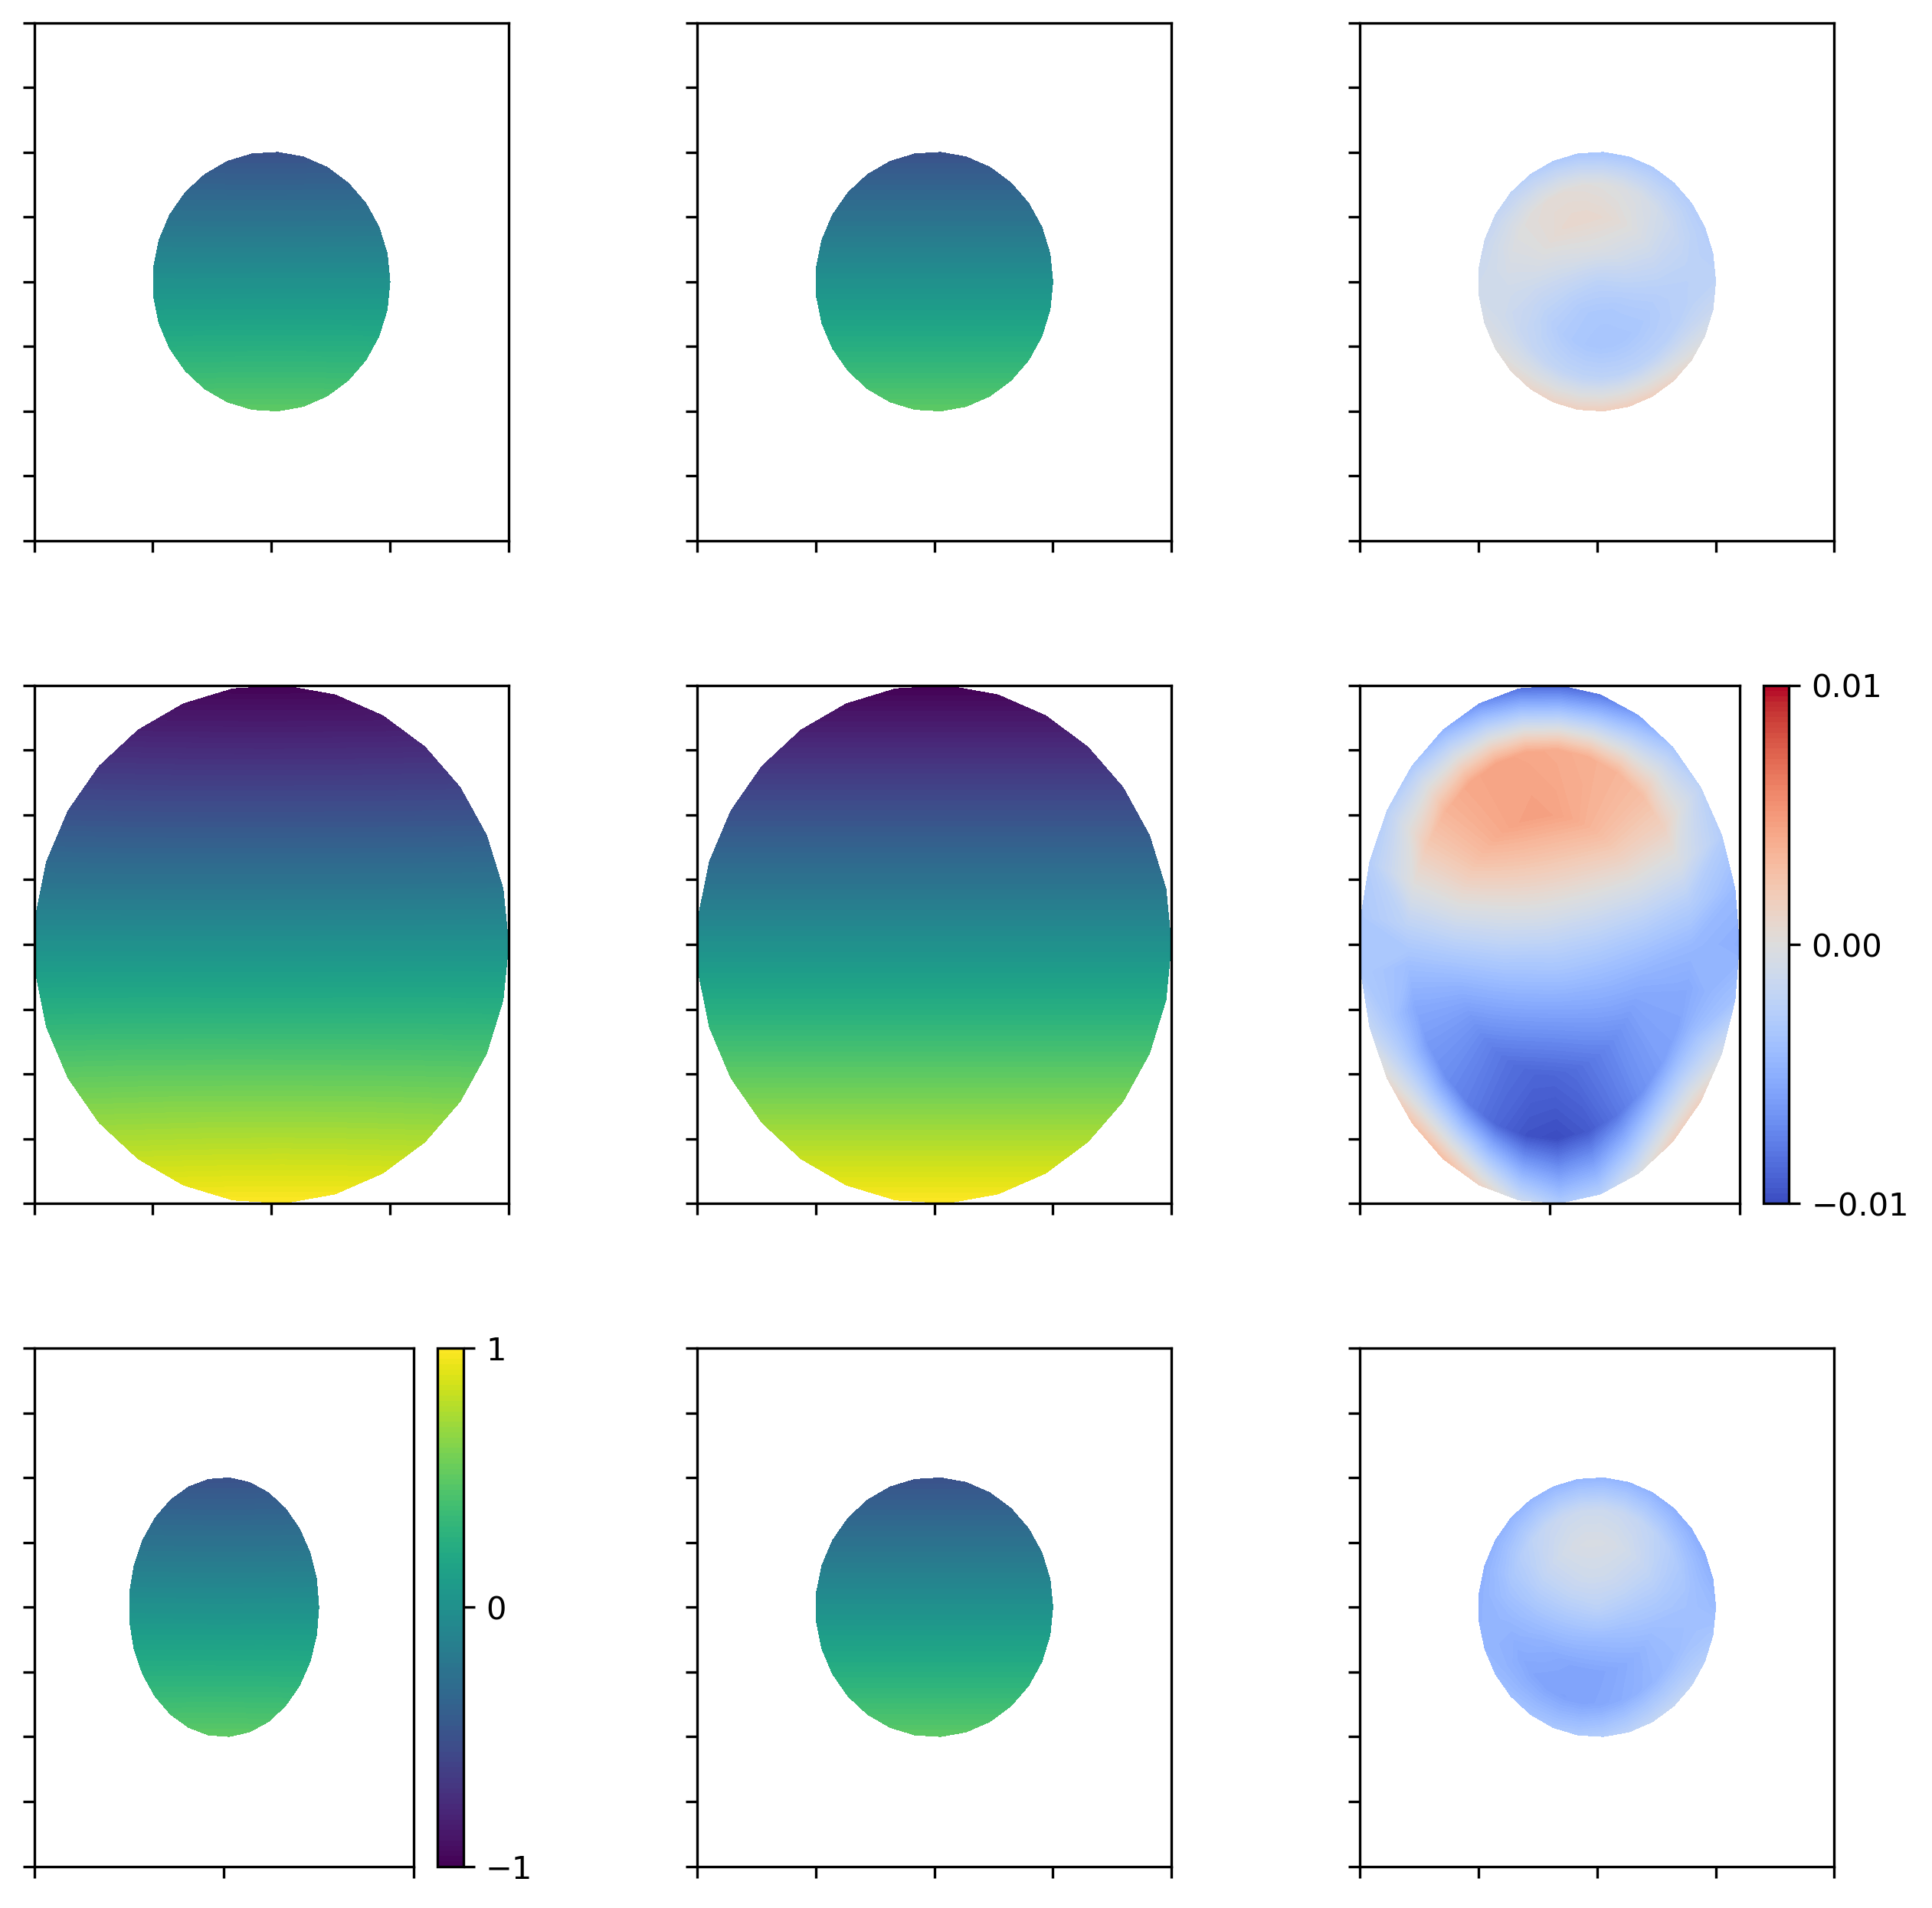

In [5]:

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

index1 = int( (numpts_phi-1)/6)
index2 = int( (numpts_phi-1)/2)
index3 = int( 5*(numpts_phi-1)/6)

levels_stokes = np.linspace(-1,1, 100)
levels_tick = np.linspace(-1,1,3)

error_levels = np.linspace(-0.01, 0.01, 100)
error_tick = np.linspace(-0.01, 0.01, 3)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9,9))
fig.tight_layout(pad=2.5)

#fig.suptitle('Learning Steady Stokes FLow in Rotating Sphere at different levels' )

contour0 = ax[0,0].contourf(x1plot[:,:,index1], x2plot[:,:,index1], 
                            u1_approx[:,:,index1], levels = levels_stokes, cmap=plt.cm.viridis)
#ax[0,0].set_title("NN Approximation of u1 velocity")
ax[0,0].set_xticklabels([])
ax[0,0].set_yticklabels([])
ax[0,0].set_xlim(-1, 1)
ax[0,0].set_ylim(-1, 1)
#plt.colorbar(contour0, ticks = levels_tick, ax=ax[0,0])

#ax[0,0].annotate(r'$z = 0.5$', xy=(0, 0.5), xycoords=ax[0,0].yaxis.label, 
                 #size='large', ha='right', va='center')

contour1 = ax[0,1].contourf(x1plot[:,:,index1], x2plot[:,:,index1], 
                        u1_plot[:,:,index1], levels = levels_stokes, cmap=plt.cm.viridis)
#ax[0,1].set_title("Analytic Solution of u1 velocity")
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])
ax[0,1].set_xlim(-1, 1)
ax[0,1].set_ylim(-1, 1)
#plt.colorbar(contour1, ticks = levels_tick, ax=ax[0,1])

contour2 = ax[0,2].contourf(x1plot[:,:,index1], x2plot[:,:,index1], 
                            u1_plot[:,:,index1] - u1_approx[:,:,index1], 
                            levels=error_levels, cmap=plt.cm.coolwarm)
#ax[0,2].set_title("Difference of Approx and True u1 velocity")
ax[0,2].set_xticklabels([])
ax[0,2].set_yticklabels([])
ax[0,2].set_xlim(-1, 1)
ax[0,2].set_ylim(-1, 1)
#plt.colorbar(contour2, ticks=error_tick, ax=ax[0,2])

contour3 = ax[1,0].contourf(x1plot[:,:,index2], x2plot[:,:,index2], u1_approx[:,:,index2], 
                            levels = levels_stokes, cmap=plt.cm.viridis)
#ax[1,0].set_title("NN Approximation of u1 velocity")
ax[1,0].set_xticklabels([])
ax[1,0].set_yticklabels([])
ax[1,0].set_xlim(-1, 1)
ax[1,0].set_ylim(-1, 1)
#plt.colorbar(contour3, ticks=levels_tick, ax=ax[1,0])
#ax[1,0].annotate(r'$z = 0$', xy=(0, 0.5), xycoords=ax[1,0].yaxis.label, size='large', 
                 #ha='right', va='center')


contour4 = ax[1,1].contourf(x1plot[:,:,index2], x2plot[:,:,index2], u1_plot[:,:,index2], 
                            levels = levels_stokes, cmap=plt.cm.viridis)
#ax[1,1].set_title("Analytic Solution of u1 velocity")
ax[1,1].set_xticklabels([])
ax[1,1].set_yticklabels([])
ax[1,1].set_xlim(-1, 1)
ax[1,1].set_ylim(-1, 1)
#plt.colorbar(contour4, ticks=levels_tick, ax=ax[1,1])


contour5 = ax[1,2].contourf(x1plot[:,:,index2], x2plot[:,:,index2], 
                            u1_plot[:,:,index2] - u1_approx[:,:,index2], 
                            levels=error_levels, cmap=plt.cm.coolwarm)
#ax[1,2].set_title("Difference of Approx and True u1 velocity")
ax[1,2].set_xticklabels([])
ax[1,2].set_yticklabels([])
ax[1,2].set_xlim(-1, 1)
ax[1,2].set_ylim(-1, 1)
plt.colorbar(contour5, ticks=error_tick, ax=ax[1,2])

contour6 = ax[2,0].contourf(x1plot[:,:,index3], x2plot[:,:,index3], u1_approx[:,:,index3], 
                            levels = levels_stokes, cmap=plt.cm.viridis)
#ax[2,0].set_title("NN Approximation of u1 velocity")
ax[2,0].set_xticklabels([])
ax[2,0].set_yticklabels([])
ax[2,0].set_xlim(-1, 1)
ax[2,0].set_ylim(-1, 1)
plt.colorbar(contour6, ticks=levels_tick, ax=ax[2,0])

#ax[2,0].annotate(r'$z = -0.5$', xy=(0, 0.5), xycoords=ax[2,0].yaxis.label, 
#                 size='large', ha='right', va='center')

contour7 = ax[2,1].contourf(x1plot[:,:,index3], x2plot[:,:,index3], u1_plot[:,:,index3],
                            levels = levels_stokes, cmap=plt.cm.viridis)
#ax[2,1].set_title("Analytic Solution of u1 velocity")
ax[2,1].set_xticklabels([])
ax[2,1].set_yticklabels([])
ax[2,1].set_xlim(-1, 1)
ax[2,1].set_ylim(-1, 1)
#plt.colorbar(contour7, ticks=levels_tick, ax=ax[2,1])

contour8 = ax[2,2].contourf(x1plot[:,:,index3], x2plot[:,:,index3], 
                            u1_plot[:,:,index3] - u1_approx[:,:,index3], 
                            levels=error_levels,cmap=plt.cm.coolwarm)
#ax[2,2].set_title("Difference of Approx and True u1 velocity")
ax[2,2].set_xticklabels([])
ax[2,2].set_yticklabels([])
ax[2,2].set_xlim(-1, 1)
ax[2,2].set_ylim(-1, 1)
#plt.colorbar(contour8, ticks=error_tick, ax=ax[2,2])